## In this notebook, we proceed to do the count vectorization, tf-idf and lda analysis of the topics present in both White House and European Commission

## Structure:
    - Hello is it me you are looking for? by Leonel Richie
    - Atomic by Blondie
    - First we take Manhanttan by Leonard Cohen

## Import functions

In [16]:
import pandas as pd
import numpy as np
import csv

import spacy
sp = spacy.load('en_core_web_sm')

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import os

from gensim.corpora.dictionary import Dictionary
from gensim import models
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from gensim.matutils import Sparse2Corpus

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim import models

import matplotlib.pyplot as plt



## Load Data

In [17]:
path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename_EC ="data/theeuropeancommission_preprocessed.csv"
EC_data = pd.read_csv(os.path.join(path, filename_EC), sep=',', encoding='utf-8')
#Checking everything is fine
EC_data.head(5)

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine
0,European Commission authorises second safe and...,2021-01-06,Press Release,"Today, the European Commission has granted a c...",today european commission grant conditional ma...,european commission authorise second safe effe...,0
1,Statement by President von der Leyen on the re...,2021-01-07,Statement,What happened in Washington yesterday is as ...,happen washington yesterday appalling outrageo...,statement president von der leyen recent devel...,0
2,Commission proposes to purchase up to 300 mill...,2021-01-08,Press Release,The European Commission today proposed to the ...,european commission today propose EU member st...,commission propose purchase 300 million additi...,0
3,Speech by President von der Leyen at the One P...,2021-01-11,Speech,"Merci Monsieur le Président.\nCher Emmanuel,\n...",merci monsieur le président cher emmanuel deli...,speech president von der leyen one planet summit,0
4,Coronavirus: Commission concludes exploratory ...,2021-01-12,Press Release,"Today, the European Commission concluded explo...",today european commission conclude exploratory...,coronavirus commission conclude exploratory ta...,0


In [18]:
filename ="data/thewhitehouse_preprocessed_p1.csv"
WH_data_1 = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
filename ="data/thewhitehouse_preprocessed_p2.csv"
WH_data_2 = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
WH_data = pd.concat([WH_data_1, WH_data_2], ignore_index=True)
#Checking everything is fine
WH_data.head(5)

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine
0,Fact Sheet: President-elect Biden Outlines COV...,2021-01-15,Statement,Effectively and equitably vaccinating the U.S....,effectively equitably vaccinate US population ...,fact sheet president elect biden outlines covi...,0
1,Fact Sheet: List of Agency Actions for Review,2021-01-20,Statement,"Actions Address the COVID-19 Pandemic, Provide...",actions address covid19 pandemic provide econo...,fact sheet list agency actions review,0
2,Fact Sheet: President Biden Sends Immigration ...,2021-01-20,Statement,The U.S. Citizenship Act of 2021 establishes a...,US citizenship act 2021 establish new system r...,fact sheet president biden sends immigration b...,0
3,"A Letter to Dr. Eric S. Lander, the President’...",2021-01-20,Statement,"On January 15, 2021, then-President-Elect Bide...",january 15 2021 president elect biden send fol...,letter dr eric lander president science adviso...,0
4,Paris Climate Agreement,2021-01-20,Statement,ACCEPTANCE ON BEHALF OF THE UNITED STATES OF A...,acceptance ON BEHALF UNITED STATES AMERICA jos...,paris climate agreement,0


## CV, TD-IDF and LDA - Goal choose Min_DF, Max_DF to for LDA Topic Analysis

In [4]:

def analyze_text_data(data, min_df, max_df):
    # Previous setup for CountVectorizer and TfidfVectorizer
    
    # Initialize CountVectorizer with specified parameters
    cv = CountVectorizer(ngram_range=(1,2), lowercase=True, min_df=min_df, max_df=max_df, stop_words='english')
    
    # Fit CountVectorizer and transform text and title data
    cv.fit(data.text_preproc)
    vectorized_text = cv.transform(data.text_preproc).toarray()
    vectorized_title = cv.transform(data.titles_preproc).toarray()
    vectorized_text_title_weight = 2 * vectorized_title + vectorized_text
    
    # Apply SVD to CountVectorizer output
    svd = TruncatedSVD(n_components=10)
    U = svd.fit_transform(vectorized_text_title_weight)
    VT = svd.components_
    
    # Initialize TfidfVectorizer with specified parameters
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=min_df, max_df=max_df)
    
    # Fit and transform text data using TfidfVectorizer
    tfidf.fit(data.text_preproc)  # Adjusted to fit the correct dataset
    tfidf_matrix_text = tfidf.transform(data.text_preproc)
    tfidf_matrix_title = tfidf.transform(data.titles_preproc)
    
    # Perform SVD on TF-IDF matrices
    svd_tfidf = TruncatedSVD(n_components=10)
    U_text = svd_tfidf.fit_transform(tfidf_matrix_text)
    U_title = svd_tfidf.transform(tfidf_matrix_title)
    
    # LDA Analysis
    dtm = 2 * vectorized_title + vectorized_text  # Reuse weighted document-term matrix
    dtm_sparse = csr_matrix(dtm)  # Convert to sparse format for gensim
    corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)  # Convert to gensim corpus
    dictionary = Dictionary.from_corpus(corpus, id2word=dict((id, word) for word, id in cv.vocabulary_.items()))
    
    # Build LDA model
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10, random_state=10)
    
    # Collect top words for LDA
    lda_output = "Top words associated with each topic (LDA):\n"
    topics = lda_model.show_topics(num_words=10, formatted=False)
    for topic_num, topic_words in topics:
        words = ', '.join([word for word, _ in topic_words])
        lda_output += f"Topic {topic_num + 1}: {words}\n"

    # Collect outputs for Count Vectorization and TF-IDF Vectorization
    count_vectorization_output = "Top words associated with each topic (Count Vectorization):\n"
    tfidf_vectorization_output = "\nTop words associated with each topic (TF-IDF Vectorization):\n"
    
    # Collect top words for Count Vectorization
    count_vectorization_output += "Top words associated with each topic (Count Vectorization):\n"
    feature_names_count = cv.get_feature_names_out()
    for topic_idx, topic in enumerate(VT):
        top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
        top_words = [feature_names_count[i] for i in top_words_idx]
        count_vectorization_output += f"Topic {topic_idx+1}: {', '.join(top_words)}\n"
    
    # Collect top words for TF-IDF Vectorization
    tfidf_vectorization_output += "\nTop words associated with each topic (TF-IDF Vectorization):\n"
    feature_names_tfidf = tfidf.get_feature_names_out()
    for topic_idx, topic in enumerate(svd_tfidf.components_):
        top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
        top_words = [feature_names_tfidf[i] for i in top_words_idx]
        tfidf_vectorization_output += f"Topic {topic_idx+1}: {', '.join(top_words)}\n"    
    
    # Return all the collected outputs
    return count_vectorization_output, tfidf_vectorization_output, lda_output

In [5]:
def run_and_log_analyses(min_df_values, max_df_values, datasets):
    with open("analysis_output.txt", "w") as file:
        for dataset_name, data in datasets.items():
            file.write(f"Analyzing dataset: {dataset_name}\n\n")
            for min_df in min_df_values:
                for max_df in max_df_values:
                    # Call analyze_text_data and unpack the returned outputs
                    count_vectorization_output, tfidf_vectorization_output, lda_output = analyze_text_data(data, min_df, max_df)
                    
                    file.write(f"min_df: {min_df}, max_df: {max_df}\n")
                    file.write(count_vectorization_output + "\n")
                    file.write(tfidf_vectorization_output + "\n")
                    file.write(lda_output + "\n\n")
            file.write("\n")  # Separator between datasets
    print(f"Analysis completed. Output written to analysis_output.txt")

    

In [6]:
min_df_values = [0.001, 0.01, 0.02, 0.05, 0.1]
max_df_values = [0.2, 0.3, 0.4, 0.5, 0.6]

datasets = {
    "EC_data": EC_data,
    "WH_data": WH_data
}

run_and_log_analyses(min_df_values, max_df_values, datasets)

Analysis completed. Output written to analysis_output.txt


## Topics analysis

In [36]:
def analyze_text_with_lda(data, min_df, max_df):
    # Initialize CountVectorizer
    cv = CountVectorizer(ngram_range=(1, 2), lowercase=False, min_df=min_df, max_df=max_df)
    
    # Fit CountVectorizer and transform text data
    cv.fit(data.text_preproc)
    vectorized_text = cv.transform(data.text_preproc).toarray()
    vectorized_title = cv.transform(data.titles_preproc).toarray()

    # Combine text and title vectorized data with specified weight
    dtm = 2 * vectorized_title + vectorized_text

    # Convert the combined DTM to a sparse format for gensim
    dtm_sparse = csr_matrix(dtm)

    # Convert sparse matrix to gensim corpus
    corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

    # Create a Gensim dictionary from the CountVectorizer vocabulary
    dictionary = Dictionary()
    cv_vocabulary = {id_: token for token, id_ in cv.vocabulary_.items()}
    # Manually populate the Dictionary object
    dictionary.id2token = cv_vocabulary
    dictionary.token2id = {token: id_ for id_, token in cv_vocabulary.items()}

    # Hardcoded parameters for LDA
    num_topics = 10
    passes = 10
    random_state = 10

    # Build LDA model
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=random_state)

    # Display the topics
    print("Top words associated with each topic (LDA):")
    topics = lda_model.show_topics(num_words=10, formatted=False)
    for topic_num, topic_words in topics:
        words = ', '.join([word for word, _ in topic_words])
        print(f"Topic {topic_num + 1}: {words}")

    return lda_model, corpus



In [37]:
#We choose one lda and then role it, this is for text purposes
lda_model_ECB, corpus_ECB = analyze_text_with_lda(EC_data, 0.02, 0.5)
lda_model_WH, corpus_WH = analyze_text_with_lda(WH_data, 0.1, 0.4)

Top words associated with each topic (LDA):
Topic 1: ukraine, war, want, russia, president von, know, von, von der, leyen, der leyen
Topic 2: social, digital, education, programme, der leyen, leyen, der, von der, von, AI
Topic 3: climate, security, cooperation, partnership, transition, international, economic, agreement, joint, defence
Topic 4: recovery, resilience, recovery resilience, payment, request, plan, assessment, reform, facility, milestone
Topic 5: vaccine, health, gateway, global gateway, partnership, africa, million, development, partner, leyen
Topic 6: gas, russia, russian, price, ukraine, bauhaus, new european, european bauhaus, der, leyen
Topic 7: plan, resilience, recovery, recovery resilience, resilience plan, reform, digital, green, transition, measure
Topic 8: ukraine, million, financial, assistance, international, provide, russia, der leyen, measure, von
Topic 9: china, change, digital, woman, trade, want, right, like, climate, must
Topic 10: climate, green, market,

In [38]:
def aggregate_topic_shares(data, lda_model, corpus):
    # Get document topics
    doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]
    
    # Initialize topic columns in EC_data
    for topic_num in range(10):
        data[f'topic_{topic_num}'] = 0.0
    
    # Fill topic share in EC_data
    for i, doc_distribution in enumerate(doc_topics):
        for topic_num, prob in doc_distribution:
            data.at[i, f'topic_{topic_num}'] = prob
    
    # Calculate sum of topic shares and check if it's close to 1
    data['topic_sum'] = data[[f'topic_{i}' for i in range(10)]].sum(axis=1)
    data['sum_is_1'] = np.isclose(data['topic_sum'], 1.0)
    
    # Calculate words per topic
    data['length_in_words'] = data['text_preproc'].apply(lambda x: len(x.split()))
    for i in range(10):
        data[f'words_topic_{i}'] = data[f'topic_{i}'] * data['length_in_words']
    
    # Correctly convert the 'Date' column to 'year_month' format
    data['year_month'] = pd.to_datetime(data['Date']).dt.strftime('%Y-%m')
    aggregation_data = data[['year_month'] + [f'words_topic_{i}' for i in range(10)]]
    grouped_data = aggregation_data.groupby(['year_month']).sum().reset_index()
    
    # Adjust sums by alpha_prior and calculate topic shares
    alpha_prior = lda_model.alpha
    total_alpha_prior = sum(alpha_prior)
    for i in range(10):
        grouped_data[f'topic_share_{i}'] = (grouped_data[f'words_topic_{i}'] + alpha_prior[i]) / (grouped_data[[f'words_topic_{j}' for j in range(10)]].sum(axis=1) + total_alpha_prior)
    
    # Select final columns for the result DataFrame
    final_columns = ['year_month'] + [f'topic_share_{i}' for i in range(10)]
    result_df = grouped_data[final_columns]
    
    return result_df

EC_topic_shares = aggregate_topic_shares(EC_data, lda_model_ECB, corpus_ECB)
WH_topic_shares = aggregate_topic_shares(WH_data, lda_model_WH, corpus_WH)

## Trend Analysis for the Communication of the European Commission

In [22]:
EC_topic_shares.head(5)

,year_month,topic_share_0,topic_share_1,topic_share_2,topic_share_3,topic_share_4,topic_share_5,topic_share_6,topic_share_7,topic_share_8,topic_share_9
0,2021-01,0.108456,0.129491,0.008661,0.004210,0.268198,0.041759,0.000608,0.091196,0.156569,0.190853
1,2021-02,0.081546,0.142201,0.014818,0.004474,0.279757,0.003173,0.035197,0.036690,0.188762,0.213382
2,2021-03,0.081236,0.261304,0.032297,0.007820,0.167803,0.013080,0.014861,0.095617,0.113253,0.212729
3,2021-04,0.161430,0.103299,0.044516,0.002977,0.187642,0.136090,0.033413,0.113220,0.111066,0.106347
4,2021-05,0.137019,0.143627,0.040193,0.001751,0.317998,0.023974,0.013664,0.093887,0.057841,0.170048


In [26]:
# Adjusting topic labels with "(Ukraine)" where relevant
topic_labels = [
    "Geopolitics (Ukraine)", "Trade Security", "Health",
    "Global Cooperation", "Economic Recovery", "Financial Aid (Ukraine)",
    "Regional Reform (Ukraine)", "Climate Action", "Leadership", "Energy Transition"
]

# Creating a dictionary for renaming without "topic_share_"
EC_topic_shares_dic = {f"topic_share_{i}": topic for i, topic in enumerate(topic_labels)}

# Renaming the columns in the DataFrame
EC_topic_shares = EC_topic_shares.rename(columns=EC_topic_shares_dic)


In [27]:
EC_topic_shares.head(5)

,year_month,Geopolitics (Ukraine),Trade Security,Health,Global Cooperation,Economic Recovery,Financial Aid (Ukraine),Regional Reform (Ukraine),Climate Action,Leadership,Energy Transition
0,2021-01,0.108456,0.129491,0.008661,0.004210,0.268198,0.041759,0.000608,0.091196,0.156569,0.190853
1,2021-02,0.081546,0.142201,0.014818,0.004474,0.279757,0.003173,0.035197,0.036690,0.188762,0.213382
2,2021-03,0.081236,0.261304,0.032297,0.007820,0.167803,0.013080,0.014861,0.095617,0.113253,0.212729
3,2021-04,0.161430,0.103299,0.044516,0.002977,0.187642,0.136090,0.033413,0.113220,0.111066,0.106347
4,2021-05,0.137019,0.143627,0.040193,0.001751,0.317998,0.023974,0.013664,0.093887,0.057841,0.170048


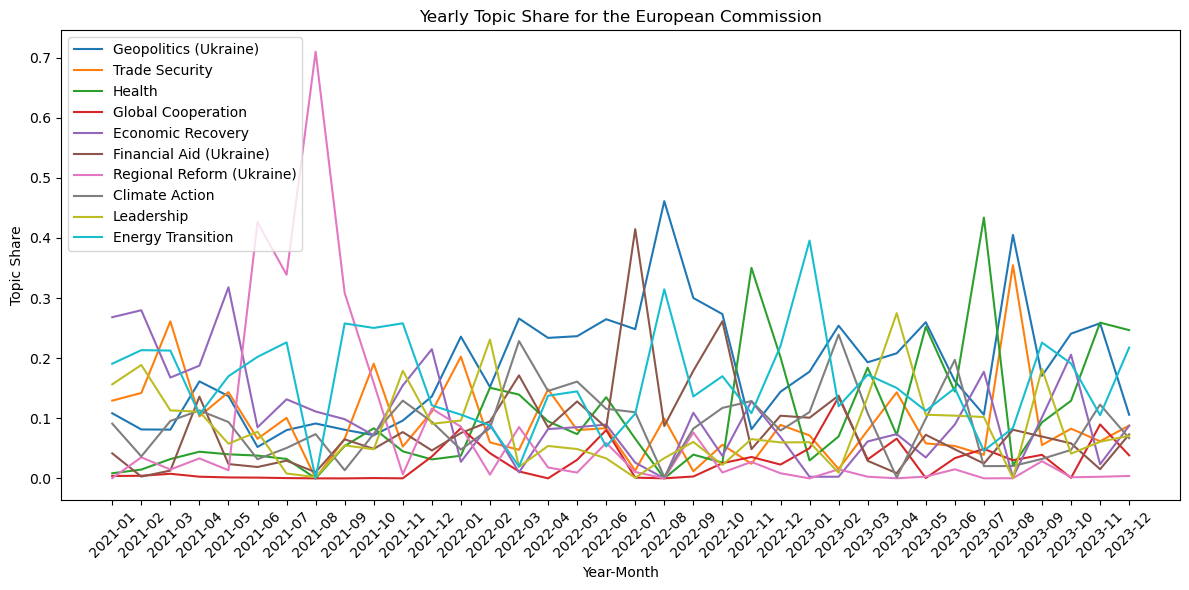

In [28]:
# Assuming EC_topic_shares is your DataFrame after renaming columns
plt.figure(figsize=(12, 6))

# List of topic labels for legend
topic_labels = [
    "Geopolitics (Ukraine)", "Trade Security", "Health",
    "Global Cooperation", "Economic Recovery", "Financial Aid (Ukraine)",
    "Regional Reform (Ukraine)", "Climate Action", "Leadership", "Energy Transition"
]

# Plot each topic share over time
for topic in topic_labels:
    plt.plot(EC_topic_shares['year_month'], EC_topic_shares[topic], label=topic)

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for the European Commission')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()


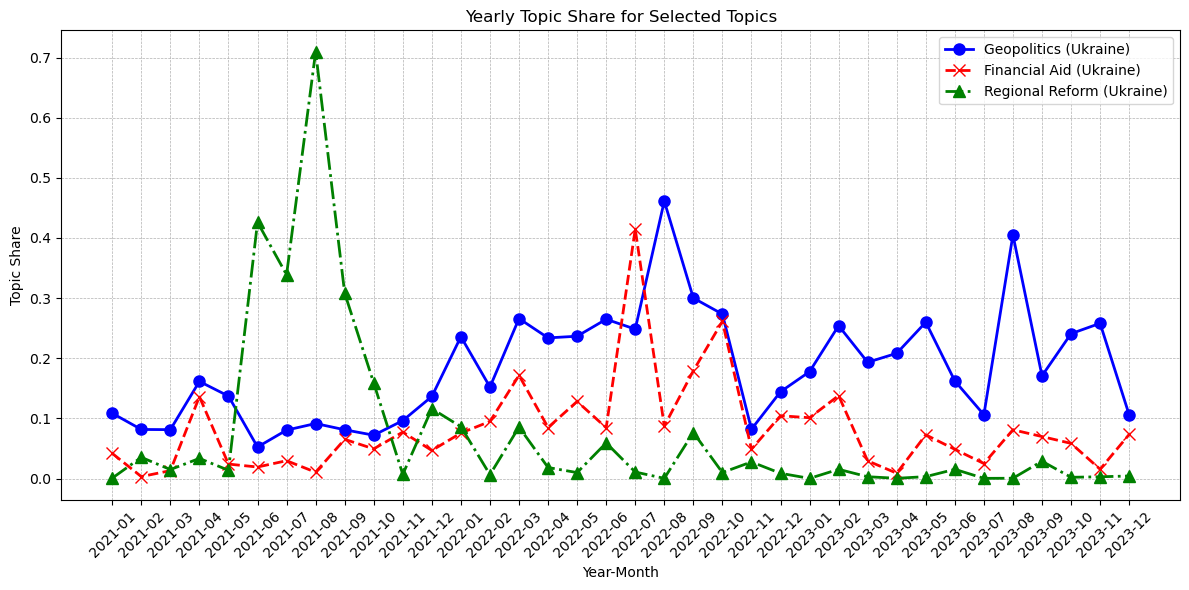

In [30]:
# Define the topics to plot
topics_to_plot = [
    "Geopolitics (Ukraine)",
    "Financial Aid (Ukraine)",
    "Regional Reform (Ukraine)"
]

# Define colors and styles for each topic for clarity in the plot
plot_styles = {
    "Geopolitics (Ukraine)": {"marker": 'o', "linestyle": '-', "color": 'blue', "linewidth": 2, "markersize": 8},
    "Financial Aid (Ukraine)": {"marker": 'x', "linestyle": '--', "color": 'red', "linewidth": 2, "markersize": 8},
    "Regional Reform (Ukraine)": {"marker": '^', "linestyle": '-.', "color": 'green', "linewidth": 2, "markersize": 8}
}

plt.figure(figsize=(12, 6))

# Loop through each topic and plot
for topic in topics_to_plot:
    plt.plot(EC_topic_shares['year_month'], EC_topic_shares[topic], label=topic, **plot_styles[topic])

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels, title, and gridlines
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for the Topics Related to Ukraine')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend()
        
# Show plot
plt.tight_layout()
plt.show()


## Trend Analysis for the Communication of the White House

In [39]:
WH_topic_shares.head(5)

,year_month,topic_share_0,topic_share_1,topic_share_2,topic_share_3,topic_share_4,topic_share_5,topic_share_6,topic_share_7,topic_share_8,topic_share_9
0,2021-01,0.060743,0.110657,0.028912,0.058816,0.157465,0.298495,0.024671,0.076345,0.095964,0.087932
1,2021-02,0.034569,0.189191,0.034166,0.093369,0.093165,0.348763,0.037897,0.033901,0.045113,0.089865
2,2021-03,0.029914,0.194158,0.023882,0.100963,0.095670,0.298391,0.033877,0.080015,0.037315,0.105815
3,2021-04,0.033219,0.139510,0.032671,0.075370,0.156292,0.223702,0.034527,0.120437,0.076722,0.107549
4,2021-05,0.048251,0.148352,0.045670,0.115956,0.075072,0.245312,0.043921,0.098171,0.075345,0.103950


In [40]:
topic_labels = [
    "Diplomatic Relations with Ukraine", "Economic Policy", "Clean Energy & Infrastructure",
    "Public Discourse", "Social Justice & Health", "COVID-19 Response",
    "National Pride & Military", "Governance & Education", "Public Sentiment",
    "Federal Programs & Support"
]

# Creating a dictionary for renaming without "topic_share_"
WH_topic_shares_dic = {f"topic_share_{i}": topic for i, topic in enumerate(topic_labels)}

# Renaming the columns in the DataFrame
WH_topic_shares = WH_topic_shares.rename(columns=WH_topic_shares_dic)

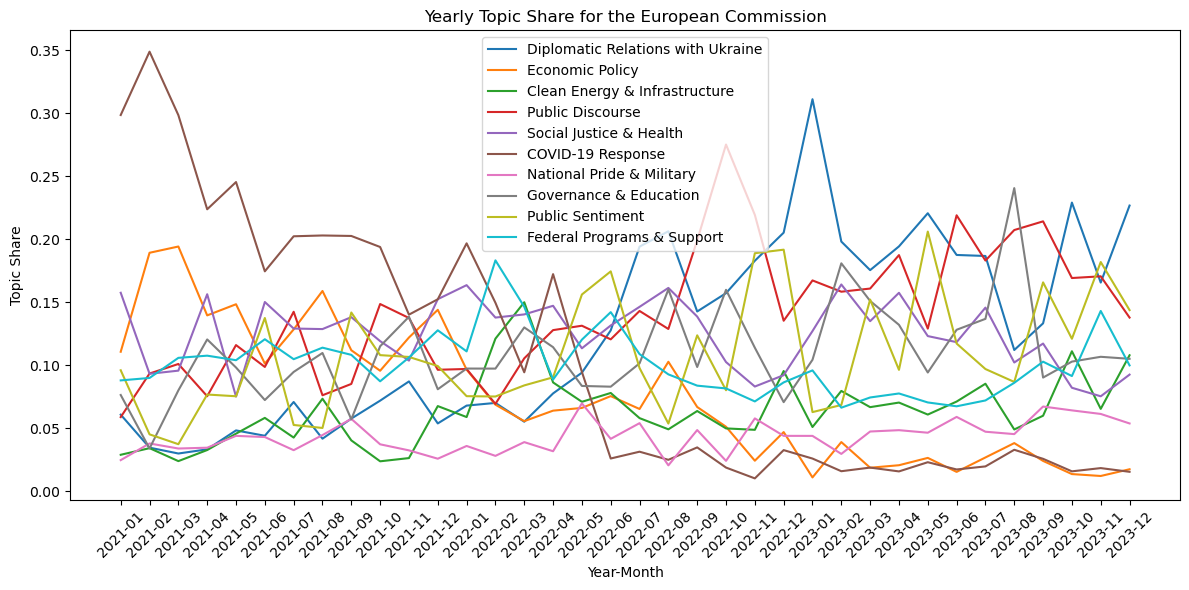

In [42]:
# Assuming EC_topic_shares is your DataFrame after renaming columns
plt.figure(figsize=(12, 6))

topic_labels = [
    "Diplomatic Relations with Ukraine", "Economic Policy", "Clean Energy & Infrastructure",
    "Public Discourse", "Social Justice & Health", "COVID-19 Response",
    "National Pride & Military", "Governance & Education", "Public Sentiment",
    "Federal Programs & Support"
]

# Plot each topic share over time
for topic in topic_labels:
    plt.plot(WH_topic_shares['year_month'], WH_topic_shares[topic], label=topic)

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for the White House')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()

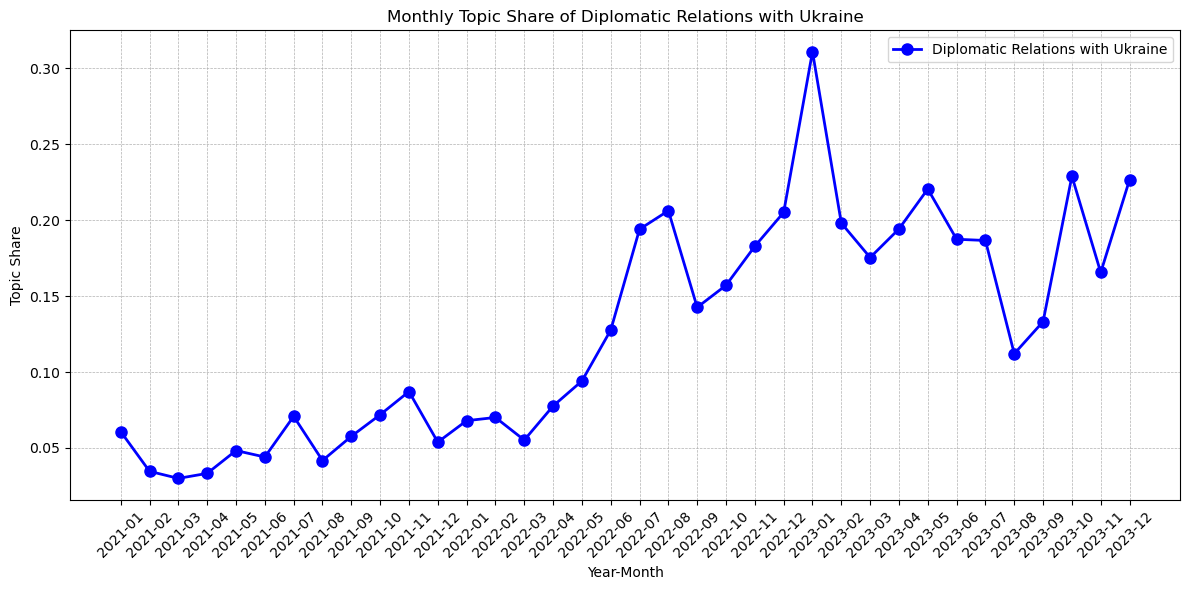

In [46]:
# Define the topics to plot
topics_to_plot = [
    "Diplomatic Relations with Ukraine",
]

# Define colors and styles for each topic for clarity in the plot
plot_styles = {
    "Diplomatic Relations with Ukraine": {"marker": 'o', "linestyle": '-', "color": 'blue', "linewidth": 2, "markersize": 8},
}

plt.figure(figsize=(12, 6))

# Loop through each topic and plot
for topic in topics_to_plot:
    plt.plot(WH_topic_shares['year_month'], WH_topic_shares[topic], label=topic, **plot_styles[topic])

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels, title, and gridlines
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Monthly Topic Share of Diplomatic Relations with Ukraine')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend()

# Show plot
plt.tight_layout()
plt.show()
